In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy import integrate, signal
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from toy_models import *
%matplotlib widget

# Quantify bif point

In [35]:
bifurcation = []

for i in range(15,50,5):
    with open(f'k50.0_t{i}_simpl.pkl', 'rb') as f:
        params_ksmall, res_ksmall = pickle.load(f)
        
    x_limit = i # check if reasonable
    y_threshold_initial = 1.0
    y_threshold = 10.0

    upper_target_trajectories = []
    lower_target_trajectories = []

    for r in res_ksmall:
        # Check if the trajectory goes straight at the beginning
        if np.all(np.abs(r.y[1][r.y[0] < x_limit]) < y_threshold_initial):
            # If it does, check if the trajectory reaches the upper target
            if r.y[1][-1] > y_threshold:
                upper_target_trajectories.append(r)
            # Check if the trajectory reaches the lower target
            elif r.y[1][-1] < -y_threshold:
                lower_target_trajectories.append(r)

    # print(f'Number of upper target trajectories: {len(upper_target_trajectories)}')
    # print(f'Number of lower target trajectories: {len(lower_target_trajectories)}')

    # Lists to store the y values for each group
    y_values_upper = []
    y_values_lower = []

    # Collect y values for the upper group
    for r in upper_target_trajectories:
        y_values_upper.append(r.y[1][:7500])

    # Calculate average y values for the upper group
    avg_y_upper = np.mean(y_values_upper, axis=0)

    # Collect y values for the lower group
    for r in lower_target_trajectories:
        y_values_lower.append(r.y[1][:7500])

    # Calculate average y values for the lower group
    avg_y_lower = np.mean(y_values_lower, axis=0)

    # Find the t value where the two averages intersect
    t_intersection = np.where(np.isclose(avg_y_upper, avg_y_lower, atol=0.1))[0]
    #select value greater than 1000
    t_intersection = t_intersection[t_intersection > 1000]

    x_up_intersections = []
    x_low_intersections = []

    for r1 in upper_target_trajectories:
        for t in t_intersection:
            x_up_intersections.append(r1.y[0][t])
    
    for r2 in lower_target_trajectories:
        for t in t_intersection:
            x_low_intersections.append(r2.y[0][t])

    # concatenate x_up_intersections and x_low_intersections
    x_inters = np.concatenate((x_up_intersections, x_low_intersections))

    x_min = np.min(x_inters)
    x_max = np.max(x_inters)
    # print(f'x_inters: {x_inters}')
    # Calculate the average and std of the x values at the intersection
    x_intersection = np.mean(x_inters)
    x_intersection_std = np.std(x_inters)

    bifurcation.append([i, x_intersection, x_min, x_max, x_intersection_std])


/Users/eleonoragatti/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


ValueError: operands could not be broadcast together with shapes (799,) (798,) 

In [26]:
bifurcation_tdep = []

for i in range(20,50,5):

    # Load the results from the pickle file
    with open(f'k50.0_t{i}.pkl', 'rb') as f:
        params_ksmall, res_ksmall = pickle.load(f)
        
    x_limit = i # check if reasonable
    y_threshold_initial = 1.0
    y_threshold = 1.5

    # Lists to store the filtered trajectories
    upper_target_trajectories = []
    lower_target_trajectories = []

    # Analyze each trajectory
    for r in res_ksmall:
        # Check if the trajectory goes straight at the beginning
        if np.all(np.abs(r.y[1][r.y[0] < x_limit]) < y_threshold_initial):
            # If it does, check if the trajectory reaches the upper target
            if r.y[1][-1] > y_threshold:
                upper_target_trajectories.append(r)
            # Check if the trajectory reaches the lower target
            elif r.y[1][-1] < -y_threshold:
                lower_target_trajectories.append(r)

    #len(upper_target_trajectories), len(lower_target_trajectories)

    common_x_values = np.linspace(i, max([r.y[0][-1] for r in res_ksmall]), 1000) #CHECK

    avg_y_upper_filtered = []
    for r in upper_target_trajectories:
        f = interp1d(r.y[0], r.y[1], fill_value="extrapolate", bounds_error=False)
        avg_y_upper_filtered.append(f(common_x_values))

    avg_y_upper_filtered = np.nanmean(avg_y_upper_filtered, axis=0)

    # Calculate average y values for the lower group
    avg_y_lower_filtered = []
    for r in lower_target_trajectories:
        f = interp1d(r.y[0], r.y[1], fill_value="extrapolate", bounds_error=False)
        avg_y_lower_filtered.append(f(common_x_values))

    avg_y_lower_filtered = np.nanmean(avg_y_lower_filtered, axis=0)

    # Find the x values where the two averages intersect
    intersection_indices = np.where(np.isclose(avg_y_upper_filtered, avg_y_lower_filtered, atol=0.1))[0]
    intersection_points = common_x_values[intersection_indices]
    mean_intersection_point = np.mean(intersection_points)
    std_dev_intersection_point = np.std(intersection_points)

    # save i, mean_intersection_point, std_dev_intersection_point in list bifurcation_tdep
    bifurcation_tdep.append([i, mean_intersection_point, std_dev_intersection_point])



/Users/eleonoragatti/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/eleonoragatti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/Users/eleonoragatti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


In [28]:
bifurcation_tdep

[[20, 42.59178410319759, 0.2356284429933941],
 [25, 50.57452084355681, 0.24637976164173003],
 [30, 56.207246902632264, 0.20929435809625713],
 [35, 60.15013812460702, 0.2127979459958729],
 [40, 63.32832228226924, 0.21050162014413934],
 [45, 65.87512975667701, 0.21207021824222702]]

In [29]:
# bifurcation
tar_x = params_ksmall[5]
tar_y = params_ksmall[6]

# convert bifurcatin x to angle
bifurcation_angle_tdep = []
for i in range(len(bifurcation_tdep)):
    bifurcation_angle_tdep.append([bifurcation_tdep[i][0],
                              np.degrees(np.arctan(tar_y/(tar_x-bifurcation_tdep[i][1]))),
                              np.degrees(bifurcation_tdep[i][2]/(tar_x))])

In [30]:
# bifurcation
tar_x = params_ksmall[3]
tar_y = params_ksmall[4]

# convert bifurcatin x to angle
bifurcation_angle = []
for i in range(len(bifurcation)):
    bifurcation_angle.append([bifurcation[i][0],
                              np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][1]))),
                              abs(np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][1]))) - np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][2])))),
                              abs(np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][1]))) - np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][3])))),
                              np.degrees(bifurcation[i][4]/(tar_x))])

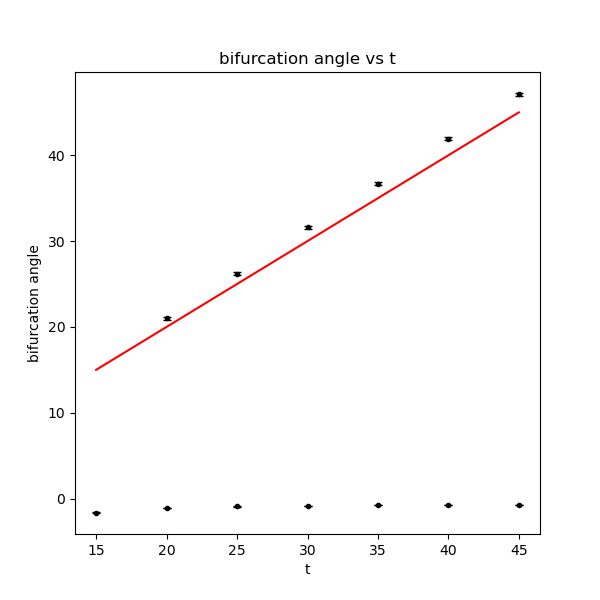

In [34]:
# plot bifurcation angle
fig, ax = plt.subplots(figsize=(6,6))
ax.errorbar([i[0] for i in bifurcation_angle_tdep], [i[1] for i in bifurcation_angle_tdep], yerr=[i[2] for i in bifurcation_angle_tdep], fmt='.', capsize=3, color='black')
ax.errorbar([i[0] for i in bifurcation_angle], [i[1] for i in bifurcation_angle], yerr=[[i[2] for i in bifurcation_angle],[i[3] for i in bifurcation_angle]], fmt='.', capsize=3, color='black')
ax.plot([i[0] for i in bifurcation_angle], [i[0] for i in bifurcation_angle], color='r')
# (ang_thresh, np.degrees(ang_crit), yerr=np.degrees(std), fmt='o', capsize=3, color='black')
plt.xlabel('t')
plt.ylabel('bifurcation angle')
plt.title('bifurcation angle vs t')
plt.show()
